In [1]:
import pandas as pd
import numpy as np
import glob
import warnings
from bs4 import BeautifulSoup
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
website_df = pd.read_csv("websites_opp115.csv")

In [3]:
website_final = website_df[['Site Human-Readable Name', 'Policy UID', 'Sectoral Data']]

In [4]:
website_final['sector'] = website_final['Sectoral Data'].str.split(":").str[0]
website_final.drop("Sectoral Data",axis = 1, inplace = True)
website_final.head()

,Site Human-Readable Name,Policy UID,sector
0,The Atlantic,20,Arts
1,IMDb,21,Kids and Teens
2,New York Times,26,Society
3,The Verge,32,Home
4,NBC Universal,33,Kids and Teens


### Load annotations data

In [5]:
dfs = []
for fname in glob.glob(r'./annotations/*.csv'):   
    policy_id = fname.split('\\')[-1].split('_')[0]
    df = pd.read_csv(fname, header=None, usecols=[3,4,5,6], names=['policy_id', 'segment_id', 'category_name', 'attr_val'])
    df['policy_id_website'] = policy_id
    dfs.append(df)
final_df = pd.concat(dfs, ignore_index=True)

In [6]:
final_df.head()

,policy_id,segment_id,category_name,attr_val,policy_id_website
0,3905,0,Other,"{""Other Type"": {""selectedText"": ""Sci-News.com ...",1017
1,3905,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati...",1017
2,3905,1,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""nformati...",1017
3,3905,2,Data Retention,"{""Personal Information Type"": {""selectedText"":...",1017
4,3905,3,First Party Collection/Use,"{""Collection Mode"": {""selectedText"": ""Not sele...",1017


### Load Raw Privacy Policy data

In [7]:
html = open(r"./sanitized_policies/20_theatlantic.com.html").read()
soup = BeautifulSoup(html, features="html.parser")
print(soup.get_text())

 Privacy Policy     Effective: January 1, 2015    At the Atlantic Monthly Group, Inc. ("The Atlantic"), we want you to enjoy and benefit from our websites and online services secure in the knowledge that we have implemented fair information practices designed to protect your privacy. Our privacy policy is applicable to The Atlantic, and The Atlantics affiliates and subsidiaries whose websites, mobile applications and other online services are directly linked (the Sites). The privacy policy describes the kinds of information we may gather during your visit to these Sites, how we use your information, when we might disclose your personally identifiable information, and how you can manage your information.  |||This privacy policy does not apply to Sites maintained by other companies or organizations to which we may link or who may link to us. We are not responsible for the actions and privacy policies of third party websites.  |||By visiting our Sites, you are accepting the practices desc

In [8]:
policy_lst = []
for fname in glob.glob(r'./sanitized_policies/*.html'):  
    policy_id = fname.split('\\')[-1].split('_')[0]
    html = open(fname).read()
    soup = BeautifulSoup(html, features="html.parser")
    soup_text = soup.get_text()
    policy_lst.append([policy_id, soup_text])
policy_df = pd.DataFrame(policy_lst, columns = ['policy_id', 'policy_text'])

In [9]:
policy_df.head()

,policy_id,policy_text
0,1017,Privacy Policy Sci-News.com is committed to ...
1,1028,"RedOrbit, Inc. Privacy Statement |||This priv..."
2,1034,"AOL Privacy Policy Last updated: June 23,..."
3,1050,"STATEMENT OF PRIVACY ( 12/23/2014, UNITED STAT..."
4,105,Amazon.com Privacy Notice |||Last updated: Ma...


### Checking Missing Values

In [10]:
website_final.isnull().sum()

Site Human-Readable Name    0
Policy UID                  0
sector                      1
dtype: int64

In [11]:
website_final[website_final['sector'].isnull()]

,Site Human-Readable Name,Policy UID,sector
67,Earth Kam,907,NaN


In [12]:
# Adding missing value based on website description
website_final.loc[website_final['Policy UID'] == 907, "sector"] = "Science"

In [13]:
website_final['sector'].value_counts(dropna = False)

Business          14
Regional          14
Arts              12
Kids and Teens     9
Health             8
Computers          8
Home               7
News               7
Society            6
Recreation         6
Games              5
Science            5
Reference          5
Sports             4
Shopping           3
World              2
Name: sector, dtype: int64

In [14]:
final_df.isnull().sum()

policy_id            0
segment_id           0
category_name        0
attr_val             0
policy_id_website    0
dtype: int64

In [15]:
policy_df.isnull().sum()

policy_id      0
policy_text    0
dtype: int64

### Basic Plotting

#### Plot 1: Different Categories in Data

Text(0.5, 0, 'Policy Count')

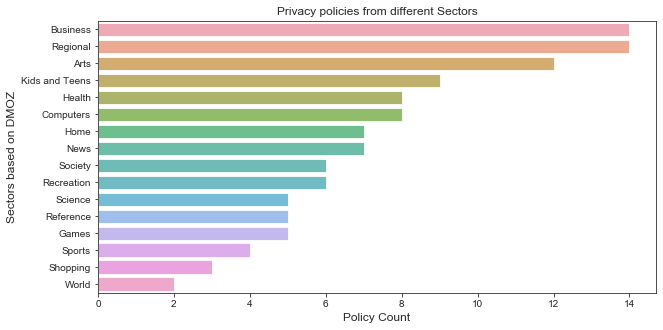

In [119]:
sns.set_style(style="whitegrid")
sns.set_style("ticks")

sector_count  = website_final['sector'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(sector_count.values, sector_count.index, alpha=0.8)
plt.title('Privacy policies from different Sectors')
plt.ylabel('Sectors based on DMOZ', fontsize=12)
plt.xlabel('Policy Count', fontsize=12)

#### Plot 2: Frequency of each labelled class 

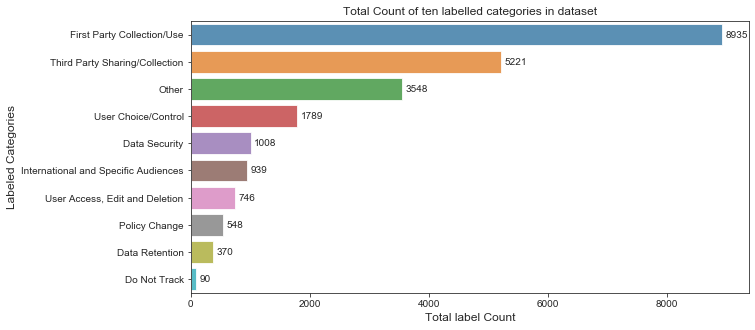

In [151]:
label_count  = final_df['category_name'].value_counts()
plt.figure(figsize=(10,5))
ax = sns.barplot(label_count.values, label_count.index, alpha=0.8)
plt.title('Total Count of ten labelled categories in dataset')
plt.ylabel('Labeled Categories', fontsize=12)
plt.xlabel('Total label Count', fontsize=12)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + 60
    _y = p.get_y() + p.get_height() - 0.3
    value = int(p.get_width())
    ax.text(_x, _y, value, ha="left")

#### Plot 3: Labelled category boxplot

Text(0.5, 0, 'Data Practice Count')

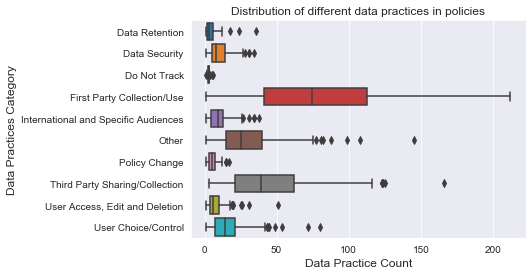

In [49]:
label_dist = final_df.groupby(['category_name','policy_id_website'])['category_name'].count().reset_index(name="count")

sns.boxplot(x="count", y="category_name", data=label_dist, orient="h")
plt.title('Distribution of different data practices in policies')
plt.ylabel('Data Practices Category', fontsize=12)
plt.xlabel('Data Practice Count', fontsize=12)

#### Percentage of Labelled Category Per Policy

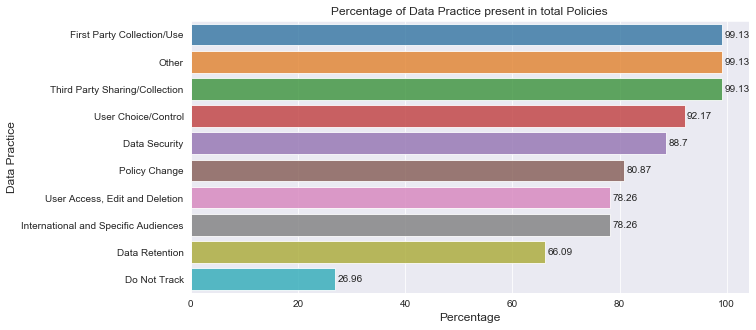

In [65]:
percentage_cat = round((y['category_name'].value_counts()/len(final_df['policy_id_website'].unique()))*100,2)
plt.figure(figsize=(10,5))
ax = sns.barplot(percentage_cat.values, percentage_cat.index, alpha=0.8)
plt.title('Percentage of Data Practice present in total Policies')
plt.ylabel('Data Practice', fontsize=12)
plt.xlabel('Percentage', fontsize=12)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + 0.4
    _y = p.get_y() + p.get_height() - 0.3
    value = float(p.get_width())
    ax.text(_x, _y, value, ha="left")

#### Plot 4: Data Practices per Policy

In [163]:
grouped_df = final_df.groupby('policy_id_website')['category_name'].count().reset_index()

Text(0.5, 0, 'Data Practices')

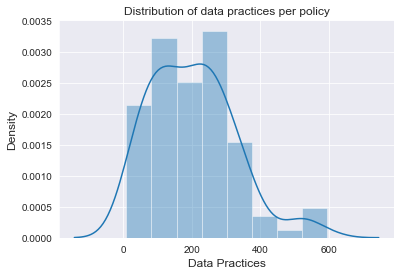

In [167]:
sns.set_style(style="darkgrid")
sns.distplot(grouped_df['category_name'])
plt.title('Distribution of data practices per policy')
plt.ylabel('Density', fontsize=12)
plt.xlabel('Data Practices', fontsize=12)

#### Plot 5: Text Length Distribution 

In [21]:
policy_df['word_count'] = policy_df['policy_text'].apply(lambda x : len(x.split()))

Text(0.5, 0, 'Word Count')

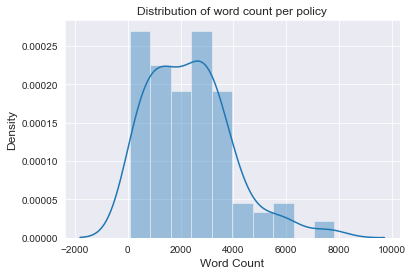

In [27]:
sns.set_style(style="darkgrid")
sns.distplot(policy_df['word_count'])
plt.title('Distribution of word count per policy')
plt.ylabel('Density', fontsize=12)
plt.xlabel('Word Count', fontsize=12)